In [98]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import least_squares
from typing import Tuple

In [99]:
def DH_Transform(th, alp,r, d ):
    theta = np.deg2rad(th)
    alpha = np.deg2rad(alp)
    M = np.array([  [np.cos(theta)  , -np.sin(theta) * np.cos(alpha)    , np.sin(alpha) * np.sin(theta)     ,r * np.cos(theta)],
                    [np.sin(theta)  , np.cos(alpha) * np.cos(theta)     , -np.sin(alpha) * np.cos(theta)    ,r * np.sin(theta)],
                    [0              , np.sin(alpha)                     , np.cos(alpha)                     , d],
                    [0              , 0                                 , 0                                 , 1]]) 
    return M

In [100]:
def pol2cart(l : float, th: float):
    """
    Convert polar information to cartesian translation

    Parameters:
        l (float): linkage's length in mm
        th (float): angle in degrees

    Returns:
        Tuple[float, float]: Converted cartesian translation
    """

    th = np.deg2rad(th)
    x = l*np.cos(th)
    y = l*np.sin(th)

    return np.array([x, y], dtype=float)

In [122]:
# Circle Equations and Find Intersection to close the loop

def circle_equations(params: Tuple[float, float], center1: np.ndarray, r1: float, center2: np.ndarray, r2: float) -> Tuple[float, float]:
    """
    System of equations representing the circles.

    Parameters:
        params (Tuple[float, float]): Coordinates (x, y) of the point to evaluate.
        center1 (np.ndarray): Center of the first circle.
        r1 (float): Radius of the first circle.
        center2 (np.ndarray): Center of the second circle.
        r2 (float): Radius of the second circle.

    Returns:
        Tuple[float, float]: Residuals for the system of equations.
    """
    x, y = params
    eq1 = (x - center1[0])**2 + (y - center1[1])**2 - r1**2
    eq2 = (x - center2[0])**2 + (y - center2[1])**2 - r2**2
    return np.array([eq1, eq2], dtype=float)

def find_circle_intersection(center1: np.ndarray, r1: float, center2: np.ndarray, r2: float) -> np.ndarray:
    """
    Find the intersection points of two circles using the Levenberg-Marquardt algorithm.

    Parameters:
        center1 (np.ndarray): Center of the first circle.
        r1 (float): Radius of the first circle.
        center2 (np.ndarray): Center of the second circle.
        r2 (float): Radius of the second circle.

    Returns:
        np.ndarray: Coordinates of the intersection points.
    """
     # Find the rightmost point among the two circles
    rightmost_point = center2[0] - r2                   # Assuming furthest to the right -> start guessing there

    # Initial guess (to the right of each circle center)
    current = np.array([rightmost_point, 0.0])

    # Use Levenberg-Marquardt to find the roots
    result = least_squares(circle_equations, current, args=(center1, r1, center2, r2))

    return result.x

def angle_between_vectors(v1, v2):
    """
    Find the angle (in degrees) between two vectors.

    Parameters:
        v1 (numpy.ndarray): First vector.
        v2 (numpy.ndarray): Second vector.

    Returns:
        float: Angle between the two vectors in degrees.
    """
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)

    cosine_angle = dot_product / (norm_v1 * norm_v2)
    angle_in_radians = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    angle_in_degrees = np.degrees(angle_in_radians)

    # Calculate the cross product to determine the direction
    cross_product = np.cross(v1, v2)

    # If the cross product is positive --> clockwise
    if cross_product > 0:
        angle_in_degrees *= -1

    return angle_in_degrees# Circle Equations and Find Intersection to close the loop

In [196]:
# Input
th_1 = 0  # Hip 1
th_2 = 0  # Hip 2
th_3 = 0  # Thigh
th_4 = 0  # Foreleg

In [197]:
# First closed chain - solving for ankle position

# Link lengths in centimeters
y01 = 104       # y distance to imu
z01 = 67.74     # z distance to imu
x01 = 5.09      # x distance to imu
l1 = 64.35  # Length of hip 1
l2 = 47.5   # Length of hip 2
l3 = 55.34  # Length of thigh
l4 = 105    # Length of foreleg
l5 = 105    # Length of shin

l6 = 105    # Length of linkage 1
l7 = 55.34  # Length of shin nub
 
# Initialize values for the joint angles (degrees)
th_3 = th_3 + 56  # Thigh
th_4 = th_4 + 120  # Foreleg

# D_H Table from the imu to thigh
d_h_table = np.array([[-90, 90, -y01, -z01],
                      [0 + th_1, 90, 0, l1],
                      [-90 + th_2, 90, 0, l2]])

th_s = 180       # Theta shin

j3 = np.array([0, 0])
j4 = j3 + pol2cart(l3, th_3)
j5 = j4 + pol2cart(l4, th_3 + th_4)

j7 = find_circle_intersection(j3, l6, j5, l7)   # Closing the loop

j6 = j5 + pol2cart(l5, (th_s + np.rad2deg(np.arctan2(j7[1] - j5[1], j7[0] - j5[0]))))   # end-effector position

j3_6 = np.array([j3,j4,j5,j7,j6]).round(4)
j3_6 = np.hstack([j3_6, np.zeros((j3_6.shape[0], 1)), np.ones((j3_6.shape[0], 1))])

In [198]:
# Create a list to store the joint positions
joint_positions = [[0,0,0]]
m00 = np.eye(4)

# Loop through each row in the DH table
i = 0
m01 = DH_Transform(d_h_table[i, 0], d_h_table[i, 1], d_h_table[i, 2], d_h_table[i, 3])
m01 = m00 @ m01
joint_position = m01[:3, 3].round(4)
joint_position[0] += x01
joint_positions.append(joint_position)

i = 1
m12 = DH_Transform(d_h_table[i, 0], d_h_table[i, 1], d_h_table[i, 2], d_h_table[i, 3])
m02 = m00 @ m01 @ m12
joint_position = m02[:3, 3].round(4)
joint_positions.append(joint_position)

i = 2
m23 = DH_Transform(d_h_table[i, 0], d_h_table[i, 1], d_h_table[i, 2], d_h_table[i, 3])
m03 = m00 @ m01 @ m12 @ m23
joint_position = m03[:3, 3].round(4)
joint_positions.append(joint_position)

p3_6 = ((m03 @ j3_6.T).T)[:, :3]

joint_positions = np.concatenate((joint_positions, p3_6[1:]), axis=0)

joint_positions

array([[   0.    ,    0.    ,    0.    ],
       [   5.09  ,  104.    ,  -67.74  ],
       [ -64.35  ,  104.    ,  -67.74  ],
       [ -64.35  ,  104.    , -115.24  ],
       [ -33.4043,  104.    , -161.1189],
       [-138.1485,  104.    , -168.4434],
       [-169.0942,  104.    , -122.5644],
       [ -79.4332,  104.    , -255.4923]])

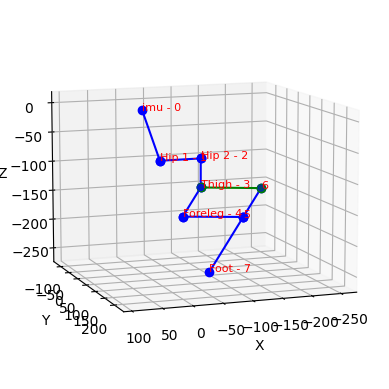

In [202]:
# Plotting the manipulator configuration
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the links

# Scatter plot of joints
ax.scatter(joint_positions[:, 0], joint_positions[:, 1], joint_positions[:, 2], c='b', marker='o', label='Joints')

j = 0
ax.plot([joint_positions[j, 0], joint_positions[j + 1, 0]],
        [joint_positions[j, 1], joint_positions[j + 1, 1]],
        [joint_positions[j, 2], joint_positions[j + 1, 2]], color='b', linestyle='-', marker='o')

j = 1
ax.plot([joint_positions[j, 0], joint_positions[j + 1, 0]],
        [joint_positions[j, 1], joint_positions[j + 1, 1]],
        [joint_positions[j, 2], joint_positions[j + 1, 2]], color='b', linestyle='-', marker='o')

j = 2
ax.plot([joint_positions[j, 0], joint_positions[j + 1, 0]],
        [joint_positions[j, 1], joint_positions[j + 1, 1]],
        [joint_positions[j, 2], joint_positions[j + 1, 2]], color='b', linestyle='-', marker='o')

j = 3
ax.plot([joint_positions[j, 0], joint_positions[j + 1, 0]],
        [joint_positions[j, 1], joint_positions[j + 1, 1]],
        [joint_positions[j, 2], joint_positions[j + 1, 2]], color='b', linestyle='-', marker='o')

j = 4
ax.plot([joint_positions[j, 0], joint_positions[j + 1, 0]],
        [joint_positions[j, 1], joint_positions[j + 1, 1]],
        [joint_positions[j, 2], joint_positions[j + 1, 2]], color='b', linestyle='-', marker='o')

j = 5
ax.plot([joint_positions[j, 0], joint_positions[j + 1, 0]],
        [joint_positions[j, 1], joint_positions[j + 1, 1]],
        [joint_positions[j, 2], joint_positions[j + 1, 2]], color='b', linestyle='-', marker='o')

ax.plot([joint_positions[5, 0], joint_positions[7, 0]],
        [joint_positions[5, 1], joint_positions[7, 1]],
        [joint_positions[5, 2], joint_positions[7, 2]], color='b', linestyle='-', marker='o')

ax.plot([joint_positions[3, 0], joint_positions[6, 0]],
        [joint_positions[3, 1], joint_positions[6, 1]],
        [joint_positions[3, 2], joint_positions[6, 2]], color='g', linestyle='-', marker='o')

# Specific names for each point
point_names = ['imu - 0', 'Hip 1 - 1', 'Hip 2 - 2', 'Thigh - 3', 'Foreleg - 4', '5', '6', 'Foot - 7']

# Label each point with specific names
for i, txt in enumerate(joint_positions):
    ax.text(txt[0], txt[1], txt[2], point_names[i], color='red', fontsize=8)


# Setting labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the view to isometric and rotate 180 degrees in the z-direction
ax.view_init(elev=10, azim=70)

# Make axis ticks equal
ax.axis('equal')

plt.show()